In [3]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pytorchtools import EarlyStopping
import math
from tqdm import tqdm

#### Numpy & Python Version 확인

In [4]:
import numpy as np
import platform

# NumPy 버전 확인
numpy_version = np.__version__

# Python 버전 확인
python_version = platform.python_version()

print(f"NumPy 버전: {numpy_version}")
print(f"Python 버전: {python_version}")

NumPy 버전: 1.26.4
Python 버전: 3.11.9


#### CUDA 사용 및 EarlyStopping 설정

In [5]:
torch.cuda.is_available()

False

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
early_stopping = EarlyStopping(patience = 5, verbose = True)

cpu


#### 모델 저장

In [6]:
# def saveModel():
#     torch.save(model.state_dict(), 'model_lstm_autoencoder_AR(2).pt') # 모델의 학습된 매개변수 파일에 저장

#### 하이퍼 파라미터 설정

In [7]:
# 하이퍼파라미터 설정
length = 12            # 윈도우 사이즈 (생성할 시계열 데이터의 길이)
trainrun = 200       # 생성할 학습 데이터 시퀀스의 수 
validrun = 100         # 생성할 검증 데이터 시퀀스의 수 

# 시계열 데이터 생성을 위한 매개변수
# 자기상관계수 (phi1, phi2별로 생성)
phi1 = np.array([0, 0.25, 0.4, 0.6, 0.8])
phi2 = np.array([0.1, 0.2, 0.3, 0.2, 0.1])

# 변화율 크기
psi1 = 0

# 공정의 수준 변화율 (delta)
de1 = 0

# 공정의 분산 변화율 (gamma)
ga = 1

#### 시계열 데이터 생성

In [8]:
np.random.seed(1)

# AR(2) 시계열 데이터 생성 함수
def ar2(phi1, phi2, delta, gamma, psi, length, run):
    # 초기 설정
    y = np.zeros(shape=(run, length))                                                         # 생성될 시계열 데이터를 저장할 빈 배열을 초기화. 배열의 크기는 (생성할 데이터 시퀀스의 수, 각 시퀀스의 길이) 
    sigma = math.sqrt((1 - phi2) / ((1 + phi2) * (1 - phi2 - phi1) * (1 - phi2 + phi1)))     # AR(2)모델의 표준 편차
    
    # 데이터 시퀀스 생성
    for j in range(0, run):                                     # 각 run 마다 랜덤 노이즈(e)를 정규분포에서 추출하여 시계열의 기본 노이즈 생성 (과적합 방지 차원)
        e = np.random.normal(loc=0, scale=1, size=length)       
        x = np.zeros(length)
        
        x[0] = e[0]                                             # x 배열 초기화하고, 첫 번째 시점의 값은 첫 번째 노이즈 값으로 설정 (시계열의 시작점에서 발생할 수 있는 임의성 반영 및 자기상관 구조 구현)

        # psi 시점 이전의 데이터 생성
        for i in range(2, psi):                                 # psi 시점 이전까지는 관리상태 데이터
            x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + e[i]     # AR(2)모델의 관리상태
            
        # psi 시점 이후의 데이터 생성 및 변동성 적용
        for i in range(psi,len(x)):                             # AR(2)모델의 이상상태
            e[i] = gamma * e[i]
            x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + e[i] 
        for i in range(psi,len(x)):                             # delta(변동성 크기 조절하는 매개변수)를 통한 추가 변동성 적용
            x[i] = x[i] + delta*sigma
        
        # 최종 데이터 반환 (각 run에 대해 생성된 시계열 데이터를 저장)  
        y[j] = x

    return y



# 다양한 매개변수 조합에 대한 시계열 데이터 세트 생성
def totaldat(run,length):
    # 빈 데이터 배열 초기화
    y = np.zeros(shape=(len(phi1), run, length))
    # 매개변수 조합별 데이터 생성
    for i, (phi_1, phi_2) in enumerate(zip(phi1, phi2)):
        y[i]= ar2(phi_1, phi_2, de1, ga, psi1, length, run)

    return y.reshape(run * len(phi1), length)                 # 생성된 데이터를 적절한 형태로 재배열


In [9]:
# 훈련용 시계열 데이터
# 데이터 생성 및 변형
train_x = totaldat(trainrun,length)                             # 훈련용 시계열 데이터 생성
train_x = train_x.reshape(trainrun*len(phi1),length)            

# 검증용 시계열 데이터
# 데이터 생성 및 변형
valid_x = totaldat(run = validrun, length = length)
valid_x = valid_x.reshape(validrun*len(phi1),length)

# PyTorch 텐서로 변환 및 장치 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.FloatTensor(train_x).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)

# DataLoader 설정
trainloader = DataLoader(train_x, shuffle=True)                  # 데이터셋에서 미니배치 자동으로 생성 후 모델 학습 및 평가 시 배치 처리를 용이하게 함 (훈련에서는 데이터를 섞어 학습 과정에서의 일반화 능력 향상)
validloader = DataLoader(valid_x, shuffle=False)                # 학습 및 검증에서는 데이터 순서 유지

In [10]:
for data in trainloader:
    print(data.shape)
    break

torch.Size([1, 12])


In [11]:
len(trainloader)

1000

In [13]:
len(validloader)

500

In [14]:
train_x.shape[1]

12

#### LSTM Autoencoder 구조

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# LSTM Encoder 클래스 정의
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(LSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.hidden_to_latent = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.hidden_to_latent(hidden[-1])

# LSTM Decoder 클래스 정의
class LSTMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, seq_length):
        super(LSTMDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.outputs_to_data = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = self.latent_to_hidden(z).unsqueeze(0)
        repeated_z = z.repeat(self.seq_length, 1, 1).transpose(0, 1)
        lstm_out, _ = self.lstm(repeated_z)
        return self.outputs_to_data(lstm_out)

# 전체 LSTM 오토인코더 모델
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim=128, latent_dim=1):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = LSTMDecoder(latent_dim, hidden_dim, input_dim, seq_length)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# 모델 인스턴스 생성 및 설정
model = LSTMAutoencoder(input_dim=length, seq_length=length, hidden_dim=128, latent_dim=1)
model = model.to(device)

In [16]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)  # You can adjust the initial lr based on your model and training needs
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([1, 12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 1.7020, Validation Loss: 1.7525
Validation loss decreased (1.752902 --> 1.752523).  Saving model ...
Epoch 2, Train Loss: 1.7014, Validation Loss: 1.7521
Validation loss decreased (1.752523 --> 1.752084).  Saving model ...
Epoch 3, Train Loss: 1.7008, Validation Loss: 1.7516
Validation loss decreased (1.752084 --> 1.751563).  Saving model ...
Epoch 4, Train Loss: 1.7001, Validation Loss: 1.7509
Validation loss decreased (1.751563 --> 1.750931).  Saving model ...
Epoch 5, Train Loss: 1.6993, Validation Loss: 1.7502
Validation loss decreased (1.750931 --> 1.750169).  Saving model ...
Epoch 6, Train Loss: 1.6983, Validation Loss: 1.7492
Validation loss decreased (1.750169 --> 1.749212).  Saving model ...
Epoch 7, Train Loss: 1.6971, Validation Loss: 1.7480
Validation loss decreased (1.749212 --> 1.748024).  Saving model ...
Epoch 8, Train Loss: 1.6956, Validation Loss: 1.7465
Validation loss decreased (1.748024 --> 1.746507).  Saving model ...
Epoch 9, Train Loss: 1.6

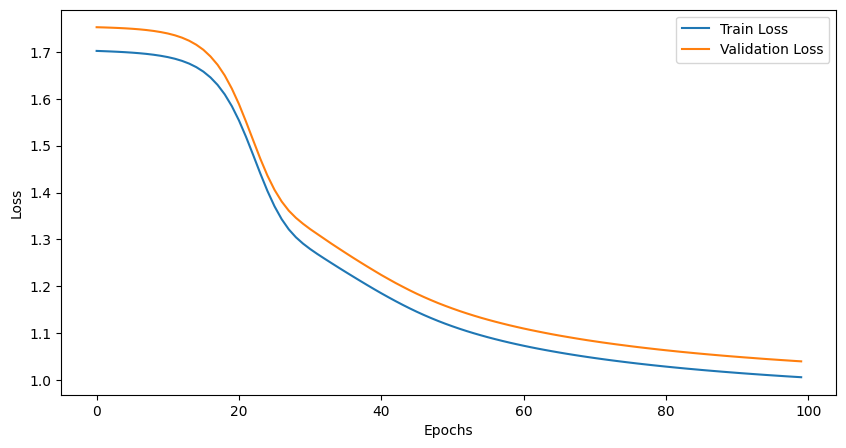

In [25]:
# def training(epochs):
#     loss_ = []
#     valoss_ = []

#     for epoch in range(epochs):
#         running_train_loss = 0.0
#         running_vall_loss = 0.0

#         # Training process
#         for data in trainloader:
#             model.train()
#             inputs = data                                                           # Assuming data is the input tensor
#             inputs = inputs.to(device)
#             optimizer.zero_grad()
#             predicted_outputs = model(inputs)
#             train_loss = criterion(predicted_outputs, inputs)
#             train_loss.backward()
#             optimizer.step()
#             running_train_loss += train_loss.item()

#         # Calculate average training loss for the epoch
#         avg_train_loss = running_train_loss / len(trainloader)
#         loss_.append(avg_train_loss)
        
#         # Validation process
#         with torch.no_grad():
#             model.eval()
#             for data in validloader:
#                 inputs = data
#                 inputs = inputs.to(device)
#                 predicted_outputs = model(inputs)
#                 val_loss = criterion(predicted_outputs, inputs)
#                 running_vall_loss += val_loss.item()

#             avg_val_loss = running_vall_loss / len(validloader)
#             valoss_.append(avg_val_loss)

#         print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
#         # Early Stopping
#         early_stopping(avg_val_loss, model)
#         if early_stopping.early_stop:
#             print("Early stopping")
#             break
 
#     # Save model
#     saveModel()
#     return loss_, valoss_  # Return the collected loss values for training and validation

# # Now when you call training, it will return the lists to be unpacked.
# loss_, valoss_ = training(epochs=100)  # Set the appropriate number of epochs

# # Loss visualization
# plt.figure(figsize=(10, 5))
# plt.plot(loss_, label='Train Loss')
# plt.plot(valoss_, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

#### 모델 불러오기

In [17]:
model.load_state_dict(torch.load('model_lstm_autoencoder_AR(2).pt', map_location=torch.device('cpu')))

<All keys matched successfully>

#### ARL0 함수

In [18]:
np.random.seed(1)

l = 12 # 윈도우 사이즈

def ar2gen(phi1, phi2, psi, delta,gamma, length) :

    e = np.random.normal(loc=0, scale = 1,size = length)
    sigma = math.sqrt((1 - phi2) / ((1 + phi2) * (1 - phi2 - phi1) * (1 - phi2 + phi1)))
    x = np.array(np.repeat(0, length), dtype= np.float64)
    x[0] = e[0]
    z = np.array(np.repeat(0, length), dtype=np.float64)

    for i in range(2, psi):
        x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + e[i]
        z[i] = x[i]
    for i in range(psi,len(x)):
        x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + gamma*e[i]
        z[i] = x[i]
    for i in range(psi,len(z)):
        z[i] = z[i] + delta * sigma

    return z

In [19]:
def arl(phi1, phi2, delta, gamma, run, length, cl) :
    rl = np.array([], dtype=np.float64)
    
    for i in tqdm(range(run)) :
        y = ar2gen(phi1, phi2, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l))
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                output = model(input)
                
                mse_loss = nn.MSELoss()
                loss = mse_loss(output[0], input[0])

                if loss > cl :

                    a = np.array([j + 1])
                    break
                elif j == len(x):
                    a = len(x)

            rl = np.append(rl,a)

    arl = np.mean(rl)
    return arl


In [29]:
### MSE

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

def arl(phi1, phi2, delta, gamma, run, length, cl, l):
    rl = np.array([], dtype=np.float64)
    mse_losses = []  # 손실 값을 저장할 리스트

    for i in tqdm(range(run)):
        y = ar2gen(phi1, phi2, psi=l-1, delta=delta, gamma=gamma, length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l))
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(len(x)):
                input = x[[j]]

                output = model(input)
                print("Output shape:", output.shape)  # output의 shape 출력

                mse_loss = nn.MSELoss()
                loss = mse_loss(output[0], input[0])
                mse_losses.append(loss.item())  # 손실 값을 저장

                if loss > cl:
                    a = np.array([j + 1])
                    break
                elif j == len(x) -  1:
                    a = len(x)

        rl = np.append(rl, a)

    arl = np.mean(rl)

    # 그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.plot(mse_losses, label='MSE Loss')
    plt.axhline(y=cl, color='r', linestyle='--', label='Control Limit (cl)')
    plt.xlabel('Iteration')
    plt.ylabel('MSE Loss')
    plt.title('MSE Loss over Iterations')
    plt.legend()
    plt.show()

    return arl


In [ ]:
def arl(phi1, phi2, delta, gamma, run, length, cl) :
    rl = np.array([], dtype=np.float64)
    
    for i in tqdm(range(run)) :
        y = ar2gen(phi1, phi2, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l))
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                output = model(input)
                print("Output shape:", output.shape)  # output의 shape 출력
                mse_loss = nn.MSELoss()
                loss = mse_loss(output[0], input[0])

                if loss > cl :

                    a = np.array([j + 1])
                    break
                elif j == len(x):
                    a = len(x)

            rl = np.append(rl,a)

    arl = np.mean(rl)
    return arl, output.shape


#### ARL1 함수

In [22]:
def arl1(phi1, phi2, run, length, cl):
    a5 = arl(phi1, phi2, 0.5, 1, run, length, cl)
    a1 = arl(phi1, phi2, 1, 1, run, length, cl)
    a2 = arl(phi1, phi2, 2, 1, run, length, cl)
    a3 = arl(phi1, phi2, 3, 1, run, length, cl)
    b5 = arl(phi1, phi2, 0.5, 1.5,run, length, cl)
    b1 = arl(phi1, phi2, 1, 1.5, run, length, cl)
    b2 = arl(phi1, phi2, 2, 1.5, run, length, cl)
    b3 = arl(phi1, phi2, 3, 1.5, run, length, cl)
    c1 = arl(phi1, phi2, 0, 1.5, run, length, cl)
    c2 = arl(phi1, phi2, 0, 2, run, length, cl)
    c3 = arl(phi1, phi2, 0, 3, run, length, cl)
    print(f'0.5: {a5}, 1:{a1},2:{a2},3:{a3}')
    print(f'0.5:{b5},1:{b1},2:{b2},3:{b3}')
    print(f'1.5:{c1},2:{c2},3:{c3}')

#### Case 1) phi1 = 0, phi2 = 0.1 일 때

##### ARL0 (threshold 임의추정)

100%|██████████| 1000/1000 [04:06<00:00,  4.06it/s]


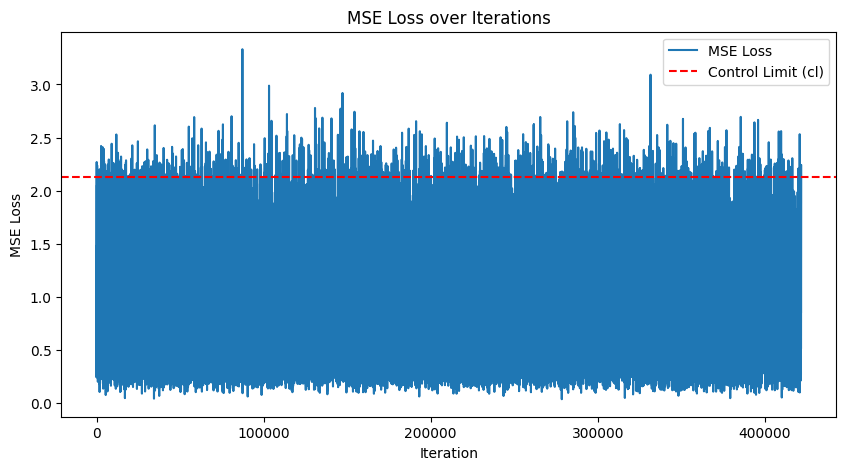

421.631

In [27]:
# MSE 그래프 수정
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.13, l=12)

100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s]


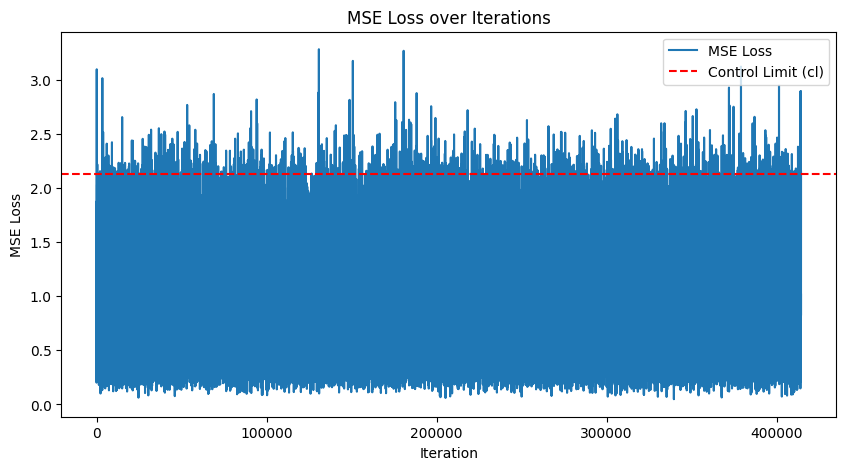

414.387

In [28]:
# output shape 확인용
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.13, l=12)

In [19]:
# run=1000 & threshold 2.13
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.13)

  0%|          | 0/1000 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]


417.906

In [20]:
# run=1000 & threshold 2
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2)

100%|██████████| 1000/1000 [02:24<00:00,  6.94it/s]


284.674

In [21]:
# run=1000 & threshold 2.09
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.09)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [03:11<00:00,  5.23it/s]


380.65

In [22]:
# run=1000 & threshold 2.08
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.08)

100%|██████████| 1000/1000 [02:57<00:00,  5.63it/s]


350.995

In [24]:
# run=10000 & threshold 2.09
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 2.09)

100%|██████████| 10000/10000 [30:55<00:00,  5.39it/s]


363.9208

In [25]:
# run=10000 & threshold 2.1
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 2.1)

100%|██████████| 10000/10000 [32:35<00:00,  5.11it/s]


382.2158

##### ARL1

In [26]:
arl1(phi1=0, phi2=0.1, run=10000, length=1000, cl= 2.09)

100%|██████████| 10000/10000 [00:26<00:00, 377.50it/s]

0.5: 307.8224, 1:177.2448,2:26.2195,3:5.0679
0.5:15.3895,1:13.2605,2:7.4241,3:3.5897
1.5:16.2938,2:7.2583,3:3.696


#### Case 2) phi1 = 0.25, phi2 = 0.2 일 때

##### ARL0 (threshold 임의추정)

In [27]:
# threshold 2.277
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.277)

100%|██████████| 1000/1000 [02:47<00:00,  5.96it/s]


327.657

In [28]:
# threshold 2.3
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.3)

100%|██████████| 1000/1000 [02:53<00:00,  5.78it/s]


333.634

In [29]:
# threshold 2.5
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.5)

100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]


501.61

In [30]:
# threshold 2.32
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.32)

100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


336.963

In [31]:
# threshold 2.38
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.38)

100%|██████████| 1000/1000 [03:22<00:00,  4.94it/s]


394.555

In [32]:
# threshold 2.36
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.36)

100%|██████████| 1000/1000 [03:14<00:00,  5.15it/s]


376.266

In [33]:
# threshold 2.35
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.35)

100%|██████████| 1000/1000 [03:15<00:00,  5.12it/s]


376.053

In [35]:
# threshold 2.33
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.33)

100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s]


362.641

In [36]:
# threshold 2.35
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 2.35)

100%|██████████| 10000/10000 [33:03<00:00,  5.04it/s]


372.5007

##### ARL1

In [37]:
arl1(phi1=0.25, phi2=0.2, run=10000, length=1000, cl= 2.35)

100%|██████████| 10000/10000 [00:31<00:00, 318.00it/s]

0.5: 319.4976, 1:167.7939,2:27.4864,3:6.5025
0.5:18.8316,1:16.2495,2:9.5338,3:4.5995
1.5:20.0136,2:8.5488,3:4.1666


#### Case 3) phi1 = 0.4, phi2 = 0.3 일 때

##### ARL0 (threshold 임의추정)

In [38]:
# threshold 2.94
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.94)

100%|██████████| 1000/1000 [02:34<00:00,  6.46it/s]


291.482

In [39]:
# threshold 3.2
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 3.2)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [03:31<00:00,  4.74it/s]


403.027

In [40]:
# threshold 3.1
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 3.1)

100%|██████████| 1000/1000 [03:04<00:00,  5.43it/s]


356.761

In [42]:
# threshold 3.13
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 3.13)

100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s]


363.392

In [43]:
# threshold 3.16
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 3.16)

100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]


378.399

In [44]:
# threshold 3.14
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 3.14)

100%|██████████| 1000/1000 [03:11<00:00,  5.21it/s]


372.07

In [45]:
# threshold 3.14
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 3.14)

100%|██████████| 10000/10000 [32:01<00:00,  5.21it/s] 


365.1518

In [46]:
# threshold 3.15
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 3.15)

100%|██████████| 10000/10000 [32:40<00:00,  5.10it/s] 


370.3189

##### ARL1

In [47]:
arl1(phi1=0.4, phi2=0.3, run=10000, length=1000, cl= 3.15)

  0%|          | 0/10000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 10000/10000 [00:35<00:00, 280.06it/s]

0.5: 306.3382, 1:157.9416,2:31.2511,3:7.3768
0.5:27.4645,1:23.4224,2:12.9014,3:5.8543
1.5:29.5474,2:11.7555,3:5.4295


#### Case 4) phi1 = 0.6, phi2 = 0.2 일 때

##### ARL0 (threshold 임의추정)

In [48]:
# threshold 3.98
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 3.98)

100%|██████████| 1000/1000 [02:25<00:00,  6.86it/s]


277.46

In [49]:
# threshold 4.3
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4.3)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s]


337.374

In [50]:
# threshold 4.5
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4.5)

100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]


400.035

In [51]:
# threshold 4.43
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4.43)

100%|██████████| 1000/1000 [03:46<00:00,  4.41it/s]


399.006

In [52]:
# threshold 4.24
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4.24)

100%|██████████| 1000/1000 [02:54<00:00,  5.74it/s]


338.274

In [53]:
# threshold 4.3
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4.3)

100%|██████████| 1000/1000 [03:14<00:00,  5.14it/s]


354.621

In [55]:
# threshold 4.37
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 4.37)

100%|██████████| 1000/1000 [03:22<00:00,  4.94it/s]


370.072

In [56]:
# threshold 4.37
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 4.37)

100%|██████████| 10000/10000 [32:16<00:00,  5.16it/s] 


374.7038

In [ ]:
# threshold 4.37
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 4.37)

##### ARL1

In [57]:
arl1(phi1=0.6, phi2=0.2, run=10000, length=1000, cl= 4.37)

  0%|          | 0/10000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 10000/10000 [00:43<00:00, 232.51it/s]

0.5: 281.7393, 1:146.2362,2:30.0024,3:7.2223
0.5:35.2859,1:28.7356,2:14.9904,3:6.56
1.5:36.6503,2:15.4315,3:6.8686


#### Case 5) phi1 = 0.8, phi2 = 0.1 일 때

##### ARL0 (threshold 임의추정)

In [58]:
# threshold 5.9
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 5.9)

100%|██████████| 1000/1000 [01:33<00:00, 10.67it/s]


184.785

In [59]:
# threshold 8
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 8)

100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]


440.316

In [60]:
# threshold 7
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 7)

100%|██████████| 1000/1000 [02:29<00:00,  6.69it/s]


291.612

In [61]:
# threshold 7.5
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 7.5)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [03:10<00:00,  5.24it/s]


375.274

In [62]:
# threshold 7.49
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 7.49)

100%|██████████| 1000/1000 [03:01<00:00,  5.52it/s]


356.055

In [63]:
# threshold 7.5
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 7.5)

100%|██████████| 10000/10000 [36:46<00:00,  4.53it/s] 


364.0695

In [64]:
# threshold 7.51
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 7.51)

  0%|          | 0/10000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 10000/10000 [37:06<00:00,  4.49it/s] 


360.4295

In [67]:
# threshold 7.54
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 7.54)

100%|██████████| 1000/1000 [03:33<00:00,  4.68it/s]


365.099

In [68]:
# threshold 7.6
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 7.6)

100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


364.112

In [69]:
# threshold 7.7
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 7.7)

100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


387.188

In [70]:
# threshold 7.63
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 7.63)

100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]


371.243

In [71]:
# threshold 7.63
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 7.63)

100%|██████████| 10000/10000 [37:44<00:00,  4.42it/s] 


372.7518

##### ARL1

In [72]:
arl1(phi1=0.8, phi2=0.1, run=10000, length=1000, cl= 7.63)

100%|██████████| 10000/10000 [00:56<00:00, 178.11it/s]

0.5: 251.0741, 1:114.5545,2:23.5539,3:5.4019
0.5:44.716,1:36.1151,2:16.5653,3:6.0176
1.5:49.0768,2:21.3912,3:9.5242
